In [3]:
#!pip install stable-baselines
#Download and install ROMs
#!gdown -q http://www.atarimania.com/roms/Roms.rar
#!pip install -q unrar
#!mkdir ./roms_atari
#!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
#!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

In [5]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#from google.colab import drive
import gym.wrappers

(210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


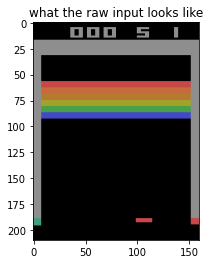

In [6]:
env = gym.make("BreakoutNoFrameskip-v4") #make_atari
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


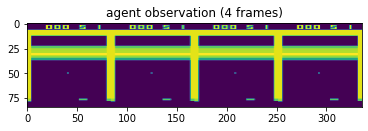

In [7]:
# Obseravtions (wrapped)
env = gym.make("BreakoutNoFrameskip-v4") #make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [8]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


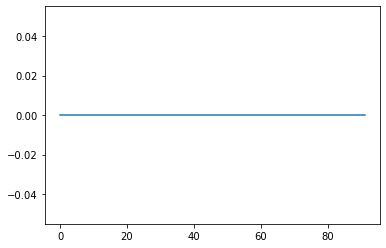

In [9]:
# Rewards
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

In [10]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Metal device set to: Apple M1 Max
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)            

2022-06-16 21:36:55.524745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-16 21:36:55.524966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [12]:
# Saving the model
#model_name = 'breakout_model_1'
#path = F"/content/gdrive/MyDrive/models/{model_name}" 
#model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)
def save_model(episode):
    model_name = f'breakout_alpha_progress_episodes_{episode}.44'
    path = f"./{model_name}"
    model.save(path)

In [24]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

MAX_EPISODES = 50000

while True and episode_count < MAX_EPISODES:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)
          

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        save_model(episode_count)
        break
        
    # save model
    if episode_count % 5000 == 0:
        save_model(episode_count)
    

running reward: 0.08 at episode 93, frame count 10000, epsilon 0.980, loss 0.00017
running reward: 0.09 at episode 185, frame count 20000, epsilon 0.972, loss 0.00007
running reward: 0.08 at episode 281, frame count 30000, epsilon 0.964, loss 0.01673
running reward: 0.05 at episode 377, frame count 40000, epsilon 0.956, loss 0.01574
running reward: 0.11 at episode 463, frame count 50000, epsilon 0.948, loss 0.00020
running reward: 0.09 at episode 556, frame count 60000, epsilon 0.940, loss 0.02642
running reward: 0.14 at episode 640, frame count 70000, epsilon 0.932, loss 0.01340
running reward: 0.07 at episode 734, frame count 80000, epsilon 0.924, loss 0.00017
running reward: 0.08 at episode 824, frame count 90000, epsilon 0.916, loss 0.00032
running reward: 0.11 at episode 910, frame count 100000, epsilon 0.908, loss 0.01324
running reward: 0.07 at episode 1003, frame count 110000, epsilon 0.900, loss 0.00009
running reward: 0.08 at episode 1097, frame count 120000, epsilon 0.892, l

running reward: 0.72 at episode 7533, frame count 940000, epsilon 0.236, loss 0.00128
running reward: 0.65 at episode 7592, frame count 950000, epsilon 0.228, loss 0.00088
running reward: 0.73 at episode 7634, frame count 960000, epsilon 0.220, loss 0.00029
running reward: 0.86 at episode 7682, frame count 970000, epsilon 0.212, loss 0.00062
running reward: 0.93 at episode 7726, frame count 980000, epsilon 0.204, loss 0.00457
running reward: 0.89 at episode 7777, frame count 990000, epsilon 0.200, loss 0.00521
running reward: 0.82 at episode 7827, frame count 1000000, epsilon 0.200, loss 0.01472
running reward: 0.85 at episode 7876, frame count 1010000, epsilon 0.199, loss 0.00159
running reward: 1.04 at episode 7914, frame count 1020000, epsilon 0.198, loss 0.00818
running reward: 0.92 at episode 7969, frame count 1030000, epsilon 0.197, loss 0.00079
running reward: 0.64 at episode 8027, frame count 1040000, epsilon 0.196, loss 0.00265
running reward: 0.67 at episode 8078, frame count

running reward: 1.36 at episode 11535, frame count 1850000, epsilon 0.115, loss 0.00074
running reward: 1.38 at episode 11571, frame count 1860000, epsilon 0.114, loss 0.00712
running reward: 1.41 at episode 11612, frame count 1870000, epsilon 0.113, loss 0.00031
running reward: 1.16 at episode 11655, frame count 1880000, epsilon 0.112, loss 0.00072
running reward: 1.24 at episode 11687, frame count 1890000, epsilon 0.111, loss 0.00172
running reward: 1.33 at episode 11723, frame count 1900000, epsilon 0.110, loss 0.00071
running reward: 1.34 at episode 11760, frame count 1910000, epsilon 0.109, loss 0.00173
running reward: 1.27 at episode 11796, frame count 1920000, epsilon 0.108, loss 0.00966
running reward: 1.34 at episode 11832, frame count 1930000, epsilon 0.107, loss 0.00466
running reward: 1.23 at episode 11874, frame count 1940000, epsilon 0.106, loss 0.00074
running reward: 1.14 at episode 11913, frame count 1950000, epsilon 0.105, loss 0.00092
running reward: 1.10 at episode 

running reward: 3.62 at episode 14005, frame count 2790000, epsilon 0.037, loss 0.00084
running reward: 3.54 at episode 14023, frame count 2800000, epsilon 0.036, loss 0.00058
running reward: 3.54 at episode 14039, frame count 2810000, epsilon 0.035, loss 0.00779
running reward: 3.70 at episode 14056, frame count 2820000, epsilon 0.034, loss 0.00148
running reward: 3.78 at episode 14070, frame count 2830000, epsilon 0.034, loss 0.01309
running reward: 3.94 at episode 14085, frame count 2840000, epsilon 0.033, loss 0.00114
running reward: 3.96 at episode 14101, frame count 2850000, epsilon 0.032, loss 0.00127
running reward: 3.83 at episode 14121, frame count 2860000, epsilon 0.031, loss 0.00100
running reward: 3.86 at episode 14137, frame count 2870000, epsilon 0.030, loss 0.00075
running reward: 3.92 at episode 14155, frame count 2880000, epsilon 0.030, loss 0.00167
running reward: 3.92 at episode 14167, frame count 2890000, epsilon 0.029, loss 0.00202
running reward: 3.73 at episode 

running reward: 3.49 at episode 15512, frame count 3700000, epsilon 0.020, loss 0.00052
running reward: 3.41 at episode 15531, frame count 3710000, epsilon 0.020, loss 0.00405
running reward: 3.80 at episode 15543, frame count 3720000, epsilon 0.020, loss 0.00031
running reward: 3.69 at episode 15564, frame count 3730000, epsilon 0.020, loss 0.01399
running reward: 3.44 at episode 15588, frame count 3740000, epsilon 0.020, loss 0.00206
running reward: 3.47 at episode 15599, frame count 3750000, epsilon 0.020, loss 0.00082
running reward: 3.52 at episode 15616, frame count 3760000, epsilon 0.020, loss 0.00043
running reward: 3.72 at episode 15631, frame count 3770000, epsilon 0.020, loss 0.00105
running reward: 3.50 at episode 15646, frame count 3780000, epsilon 0.020, loss 0.00039
running reward: 3.77 at episode 15662, frame count 3790000, epsilon 0.020, loss 0.00103
running reward: 4.06 at episode 15676, frame count 3800000, epsilon 0.020, loss 0.00186
running reward: 4.17 at episode 

running reward: 3.93 at episode 16915, frame count 4640000, epsilon 0.020, loss 0.00064
running reward: 4.07 at episode 16928, frame count 4650000, epsilon 0.020, loss 0.00041
running reward: 3.83 at episode 16944, frame count 4660000, epsilon 0.020, loss 0.00035
running reward: 4.20 at episode 16954, frame count 4670000, epsilon 0.020, loss 0.00312
running reward: 4.20 at episode 16970, frame count 4680000, epsilon 0.020, loss 0.00037
running reward: 4.31 at episode 16984, frame count 4690000, epsilon 0.020, loss 0.00083
running reward: 4.45 at episode 16998, frame count 4700000, epsilon 0.020, loss 0.00041
running reward: 4.43 at episode 17015, frame count 4710000, epsilon 0.020, loss 0.00281
running reward: 4.34 at episode 17027, frame count 4720000, epsilon 0.020, loss 0.00039
running reward: 4.38 at episode 17043, frame count 4730000, epsilon 0.020, loss 0.00045
running reward: 4.29 at episode 17054, frame count 4740000, epsilon 0.020, loss 0.00087
running reward: 4.52 at episode 

running reward: 5.07 at episode 18190, frame count 5580000, epsilon 0.020, loss 0.00044
running reward: 5.17 at episode 18200, frame count 5590000, epsilon 0.020, loss 0.00039
running reward: 5.27 at episode 18210, frame count 5600000, epsilon 0.020, loss 0.00063
running reward: 5.36 at episode 18221, frame count 5610000, epsilon 0.020, loss 0.00030
running reward: 5.41 at episode 18233, frame count 5620000, epsilon 0.020, loss 0.00060
running reward: 5.45 at episode 18243, frame count 5630000, epsilon 0.020, loss 0.00096
running reward: 5.49 at episode 18254, frame count 5640000, epsilon 0.020, loss 0.00317
running reward: 5.77 at episode 18265, frame count 5650000, epsilon 0.020, loss 0.00048
running reward: 6.11 at episode 18275, frame count 5660000, epsilon 0.020, loss 0.00056
running reward: 5.64 at episode 18292, frame count 5670000, epsilon 0.020, loss 0.00413
running reward: 5.81 at episode 18303, frame count 5680000, epsilon 0.020, loss 0.00044
running reward: 5.89 at episode 

running reward: 5.77 at episode 19394, frame count 6520000, epsilon 0.020, loss 0.00025
running reward: 5.83 at episode 19404, frame count 6530000, epsilon 0.020, loss 0.00064
running reward: 5.49 at episode 19418, frame count 6540000, epsilon 0.020, loss 0.01311
running reward: 4.77 at episode 19437, frame count 6550000, epsilon 0.020, loss 0.00045
running reward: 4.41 at episode 19457, frame count 6560000, epsilon 0.020, loss 0.00139
running reward: 3.77 at episode 19481, frame count 6570000, epsilon 0.020, loss 0.00056
running reward: 3.65 at episode 19494, frame count 6580000, epsilon 0.020, loss 0.00027
running reward: 3.48 at episode 19507, frame count 6590000, epsilon 0.020, loss 0.00142
running reward: 3.18 at episode 19530, frame count 6600000, epsilon 0.020, loss 0.00063
running reward: 3.45 at episode 19538, frame count 6610000, epsilon 0.020, loss 0.00043
running reward: 3.73 at episode 19552, frame count 6620000, epsilon 0.020, loss 0.00037
running reward: 4.11 at episode 

running reward: 5.44 at episode 20541, frame count 7430000, epsilon 0.020, loss 0.00031
running reward: 5.64 at episode 20550, frame count 7440000, epsilon 0.020, loss 0.00094
running reward: 5.61 at episode 20562, frame count 7450000, epsilon 0.020, loss 0.00022
running reward: 5.46 at episode 20571, frame count 7460000, epsilon 0.020, loss 0.00036
running reward: 5.36 at episode 20587, frame count 7470000, epsilon 0.020, loss 0.00045
running reward: 5.53 at episode 20597, frame count 7480000, epsilon 0.020, loss 0.00040
running reward: 5.36 at episode 20610, frame count 7490000, epsilon 0.020, loss 0.00046
running reward: 5.37 at episode 20622, frame count 7500000, epsilon 0.020, loss 0.00057
running reward: 5.69 at episode 20630, frame count 7510000, epsilon 0.020, loss 0.00134
running reward: 5.97 at episode 20640, frame count 7520000, epsilon 0.020, loss 0.00093
running reward: 5.72 at episode 20653, frame count 7530000, epsilon 0.020, loss 0.00231
running reward: 5.96 at episode 

running reward: 5.28 at episode 21713, frame count 8370000, epsilon 0.020, loss 0.00102
running reward: 5.51 at episode 21725, frame count 8380000, epsilon 0.020, loss 0.00025
running reward: 5.99 at episode 21733, frame count 8390000, epsilon 0.020, loss 0.00056
running reward: 6.15 at episode 21742, frame count 8400000, epsilon 0.020, loss 0.00801
running reward: 6.36 at episode 21752, frame count 8410000, epsilon 0.020, loss 0.00094
running reward: 6.35 at episode 21764, frame count 8420000, epsilon 0.020, loss 0.00566
running reward: 6.10 at episode 21775, frame count 8430000, epsilon 0.020, loss 0.00029
running reward: 6.21 at episode 21786, frame count 8440000, epsilon 0.020, loss 0.00044
running reward: 6.45 at episode 21798, frame count 8450000, epsilon 0.020, loss 0.00103
running reward: 6.27 at episode 21809, frame count 8460000, epsilon 0.020, loss 0.00044
running reward: 6.13 at episode 21821, frame count 8470000, epsilon 0.020, loss 0.00035
running reward: 6.18 at episode 

running reward: 5.56 at episode 22802, frame count 9310000, epsilon 0.020, loss 0.00197
running reward: 5.29 at episode 22817, frame count 9320000, epsilon 0.020, loss 0.00747
running reward: 5.39 at episode 22829, frame count 9330000, epsilon 0.020, loss 0.00037
running reward: 5.43 at episode 22841, frame count 9340000, epsilon 0.020, loss 0.00031
running reward: 5.37 at episode 22852, frame count 9350000, epsilon 0.020, loss 0.00020
running reward: 5.59 at episode 22863, frame count 9360000, epsilon 0.020, loss 0.00013
running reward: 5.55 at episode 22875, frame count 9370000, epsilon 0.020, loss 0.00064
running reward: 5.51 at episode 22886, frame count 9380000, epsilon 0.020, loss 0.00181
running reward: 5.82 at episode 22895, frame count 9390000, epsilon 0.020, loss 0.00500
running reward: 5.85 at episode 22906, frame count 9400000, epsilon 0.020, loss 0.00017
running reward: 6.23 at episode 22914, frame count 9410000, epsilon 0.020, loss 0.00024
running reward: 6.01 at episode 

running reward: 5.81 at episode 23872, frame count 10240000, epsilon 0.020, loss 0.00191
running reward: 5.83 at episode 23883, frame count 10250000, epsilon 0.020, loss 0.00034
running reward: 6.18 at episode 23895, frame count 10260000, epsilon 0.020, loss 0.00084
running reward: 6.49 at episode 23904, frame count 10270000, epsilon 0.020, loss 0.00796
running reward: 6.16 at episode 23916, frame count 10280000, epsilon 0.020, loss 0.00104
running reward: 5.45 at episode 23940, frame count 10290000, epsilon 0.020, loss 0.00023
running reward: 5.46 at episode 23949, frame count 10300000, epsilon 0.020, loss 0.00957
running reward: 5.49 at episode 23960, frame count 10310000, epsilon 0.020, loss 0.00061
running reward: 5.32 at episode 23973, frame count 10320000, epsilon 0.020, loss 0.01428
running reward: 5.38 at episode 23985, frame count 10330000, epsilon 0.020, loss 0.00028
running reward: 5.51 at episode 23992, frame count 10340000, epsilon 0.020, loss 0.02919
running reward: 5.47 

running reward: 5.03 at episode 24923, frame count 11170000, epsilon 0.020, loss 0.00070
running reward: 4.70 at episode 24940, frame count 11180000, epsilon 0.020, loss 0.00089
running reward: 4.70 at episode 24953, frame count 11190000, epsilon 0.020, loss 0.00034
running reward: 4.92 at episode 24961, frame count 11200000, epsilon 0.020, loss 0.00034
running reward: 4.71 at episode 24976, frame count 11210000, epsilon 0.020, loss 0.00062
running reward: 4.81 at episode 24986, frame count 11220000, epsilon 0.020, loss 0.00103
running reward: 5.04 at episode 24997, frame count 11230000, epsilon 0.020, loss 0.00102
INFO:tensorflow:Assets written to: ./breakout_alpha_progress_episodes_25000.44/assets
running reward: 5.46 at episode 25005, frame count 11240000, epsilon 0.020, loss 0.00295
running reward: 5.74 at episode 25012, frame count 11250000, epsilon 0.020, loss 0.00084
running reward: 5.92 at episode 25024, frame count 11260000, epsilon 0.020, loss 0.00061
running reward: 6.17 at 

running reward: 3.88 at episode 26120, frame count 12070000, epsilon 0.020, loss 0.00056
running reward: 3.81 at episode 26136, frame count 12080000, epsilon 0.020, loss 0.00090
running reward: 3.87 at episode 26147, frame count 12090000, epsilon 0.020, loss 0.00800
running reward: 4.32 at episode 26156, frame count 12100000, epsilon 0.020, loss 0.00150
running reward: 4.40 at episode 26172, frame count 12110000, epsilon 0.020, loss 0.00051
running reward: 4.51 at episode 26183, frame count 12120000, epsilon 0.020, loss 0.00418
running reward: 4.87 at episode 26195, frame count 12130000, epsilon 0.020, loss 0.00024
running reward: 5.16 at episode 26207, frame count 12140000, epsilon 0.020, loss 0.00043
running reward: 5.32 at episode 26219, frame count 12150000, epsilon 0.020, loss 0.00058
running reward: 5.55 at episode 26227, frame count 12160000, epsilon 0.020, loss 0.00084
running reward: 5.76 at episode 26239, frame count 12170000, epsilon 0.020, loss 0.00050
running reward: 5.84 

running reward: 5.15 at episode 27122, frame count 13000000, epsilon 0.020, loss 0.00028
running reward: 5.29 at episode 27135, frame count 13010000, epsilon 0.020, loss 0.00028
running reward: 5.05 at episode 27151, frame count 13020000, epsilon 0.020, loss 0.00034
running reward: 4.88 at episode 27165, frame count 13030000, epsilon 0.020, loss 0.00057
running reward: 4.92 at episode 27178, frame count 13040000, epsilon 0.020, loss 0.00066
running reward: 5.05 at episode 27188, frame count 13050000, epsilon 0.020, loss 0.00094
running reward: 4.86 at episode 27203, frame count 13060000, epsilon 0.020, loss 0.00037
running reward: 4.82 at episode 27217, frame count 13070000, epsilon 0.020, loss 0.00035
running reward: 4.86 at episode 27228, frame count 13080000, epsilon 0.020, loss 0.00037
running reward: 4.46 at episode 27247, frame count 13090000, epsilon 0.020, loss 0.00027
running reward: 4.55 at episode 27261, frame count 13100000, epsilon 0.020, loss 0.00026
running reward: 4.67 

running reward: 6.46 at episode 28198, frame count 13930000, epsilon 0.020, loss 0.00083
running reward: 6.47 at episode 28208, frame count 13940000, epsilon 0.020, loss 0.00143
running reward: 6.53 at episode 28217, frame count 13950000, epsilon 0.020, loss 0.00524
running reward: 6.63 at episode 28225, frame count 13960000, epsilon 0.020, loss 0.00252
running reward: 6.37 at episode 28236, frame count 13970000, epsilon 0.020, loss 0.00044
running reward: 6.43 at episode 28245, frame count 13980000, epsilon 0.020, loss 0.02501
running reward: 6.74 at episode 28253, frame count 13990000, epsilon 0.020, loss 0.00026
running reward: 6.79 at episode 28265, frame count 14000000, epsilon 0.020, loss 0.00028
running reward: 6.59 at episode 28276, frame count 14010000, epsilon 0.020, loss 0.00039
running reward: 6.45 at episode 28289, frame count 14020000, epsilon 0.020, loss 0.00046
running reward: 6.32 at episode 28299, frame count 14030000, epsilon 0.020, loss 0.00028
running reward: 6.18 

KeyboardInterrupt: 